# Tests

- Different batch sizes for pretraining - same image vs diff image vs diff image batches
    - Different noise schemes
- Reconstruction on just real vs real & complex
- Visualization of early training stages
- Comparison to wavelet recon
- Brain tests - initializing on knee vs no init

# Todo
- Finish brain stuff
- Conv layer visualization - not working need to debug
- Brain

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import sys
sys.path.insert(0, '../')
from utils import *
import sigpy as sp
import sigpy.mri as mr


In [15]:
def get_image_normalized(index, plot=False):
    data = glob("../data/test_img_slices/*.ra")
    img = get_image_old2('../data/test_img_slices/19_{}.ra'.format(index)) # same - for linux
    minv = np.min(img[:, :, 0])
    maxv = np.max(img[:, :, 0])
    normalized_img = np.expand_dims(-1 + (2 * (np.array(img[:, :, 0] - minv) / (maxv - minv))), 2)
    if plot:
        plt.imshow(normalized_img[:, :, 0], cmap='gray')
        plt.show()
    minv = np.min(normalized_img[:, :, 0])
    maxv = np.max(normalized_img[:, :, 0])
    #print(minv, maxv)
    return normalized_img


def get_subsampled_normalized(normalized_img, subs, plot=False):
    mask_files = glob("../masks/gen_masks/{}_0*".format(subs))
    mask_files = [np.fft.fftshift(np.load(m)) for m in mask_files]
    mask = mask_files[0]
    new_img = np.fft.ifft2(np.multiply(np.fft.fft2(normalized_img[:, :, 0]), mask)).astype(float)
    minv = np.min(new_img)
    maxv = np.max(new_img)
    normalized_new_img = np.expand_dims(-1 + (2 * (new_img - minv) / (maxv - minv)), 2)
    if plot:
        plt.imshow(normalized_new_img[:, :, 0], cmap='gray')
        plt.show()
    #print(np.min(normalized_new_img))
    #print(np.max(normalized_new_img))
    return normalized_new_img
def get_best_L2(all_ims, compare):
    min_mse, best = np.float('inf'), all_ims[0]
    best_index = 0
    for index in range(1, len(all_ims)):
        img = all_ims[index]
        mse = np.mean(np.square(img[:, :, 0] - compare[:, :, 0]))
        if mse < min_mse:
            min_mse = mse
            best = img
            best_index = index
    best_index -= 1 # bc first index in images is the noise
    #print(best_index, min_mse)
    return best, best_index

def get_best_L1(all_ims, compare):
    min_mse, best = np.float('inf'), all_ims[0]
    best_index = 0
    for index in range(1, len(all_ims)):
        img = all_ims[index]
        mse = np.mean(np.abs(img[:, :, 0] - compare[:, :, 0]))
        if mse < min_mse:
            min_mse = mse
            best = img
            best_index = index
    best_index -= 1 # bc first index in images is the noise
    #print(best_index, min_mse)
    return best, best_index

def get_best_L1_2chan(all_ims, compare):
    compare = np.sqrt(compare[:, :, 0] ** 2 + compare[:, :, 1] ** 2)
    min_mse, best = np.float('inf'), all_ims[0]
    best_index = 0
    for index in range(1, len(all_ims)):
        img = all_ims[index]
        img = np.sqrt(img[:, :, 0] ** 2 + img[:, :, 1] ** 2)
        mse = np.mean(np.abs(img - compare))
        if mse < min_mse:
            min_mse = mse
            best = img
            best_index = index
    best_index -= 1 # bc first index in images is the noise
    #print(best_index, min_mse)
    return best, best_index

def get_wavelet_recon(subs): 
    img = subs[:, :, 0].astype(np.complex)
    ksp = sp.fft.fft(img)
    lamda = 0.001
    W = sp.linop.Wavelet(img.shape)
    proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)
    A = sp.linop.FFT(img.shape)
    img_l1wav = np.zeros_like(img)
    img_l1wav = sp.app.LinearLeastSquares(A, ksp, img_l1wav, proxg=proxg).run()
    return np.real(img_l1wav)

def get_wavelet_recon_2chan(subs): 
    img = (subs[:, :, 0] + 1j*subs[:, :, 1]).astype(np.complex)
    ksp = sp.fft.fft(img)
    lamda = 0.001
    W = sp.linop.Wavelet(img.shape)
    proxg = sp.prox.UnitaryTransform(sp.prox.L1Reg(W.oshape, lamda), W)
    A = sp.linop.FFT(img.shape)
    img_l1wav = np.zeros_like(img)
    img_l1wav = sp.app.LinearLeastSquares(A, ksp, img_l1wav, proxg=proxg).run()
    return np.sqrt(np.real(img_l1wav)**2 + np.imag(img_l1wav)**2)

def get_image_normalized_2chan(index, plot=False):
    data = glob("../data/test_img_slices/*.ra")
    img = get_image_old2('../data/test_img_slices/19_{}.ra'.format(index)) # same - for linux
    minv = np.min(img[:, :, 0])
    maxv = np.max(img[:, :, 0])
    normalized_img = np.zeros((320, 256, 2))
    normalized_img_real = -1 + (2 * (np.array(img[:, :, 0] - minv) / (maxv - minv)))
    normalized_img[:, :, 0] = normalized_img_real
    normalized_img[:, :, 1] = img[:, :, 1]
    if plot:
        plt.imshow(np.sqrt(normalized_img[:, :, 0] ** 2 + normalized_img[:, :, 1] ** 2), cmap='gray')
        plt.show()
    minv = np.min(normalized_img[:, :, 0])
    maxv = np.max(normalized_img[:, :, 0])
    #print(minv, maxv)
    return normalized_img

def get_batch_normalized_2chan(indices):
    return np.array([get_image_normalized_2chan(ind) for ind in indices])


def get_subsampled_normalized_2chan(normalized_img, subs, plot=False):
    mask_files = glob("../masks/gen_masks/{}_0*".format(subs))
    mask_files = [np.fft.fftshift(np.load(m)) for m in mask_files]
    mask = mask_files[0]
    new_img = np.fft.ifft2(np.multiply(np.fft.fft2(normalized_img[:, :, 0]), mask))
    minv = np.min(np.real(new_img))
    maxv = np.max(np.real(new_img))
    normalized_new_img = np.zeros((320, 256, 2))
    normalized_new_img_real = -1 + (2 * (np.real(new_img) - minv) / (maxv - minv))
    normalized_new_img[:, :, 0] = normalized_new_img_real
    normalized_new_img[:, :, 1] = np.imag(new_img) 
    if plot:
        plt.imshow(np.sqrt(normalized_new_img[:, :, 0] ** 2 + normalized_new_img[:, :, 1] ** 2), cmap='gray')
        plt.show()
    #print(np.min(normalized_new_img))
    #print(np.max(normalized_new_img))
    return normalized_new_img

In [5]:
orig_img = get_image_normalized(100, plot=False)
subs_img = get_subsampled_normalized(orig_img, 2, plot=False)
subs_img_4 = get_subsampled_normalized(orig_img, 4, plot=False)
subs_img_6 = get_subsampled_normalized(orig_img, 6, plot=False)
wavelet_subs = get_wavelet_recon(subs_img)
wavelet_subs_4 = get_wavelet_recon(subs_img_4)
wavelet_subs_6 = get_wavelet_recon(subs_img_6)

c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\pywt\_multilevel.py:664: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[a_slices] = a_coeffs
c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\pywt\_multilevel.py:690: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[slice_array] = d
GradientMethod:   0%|      

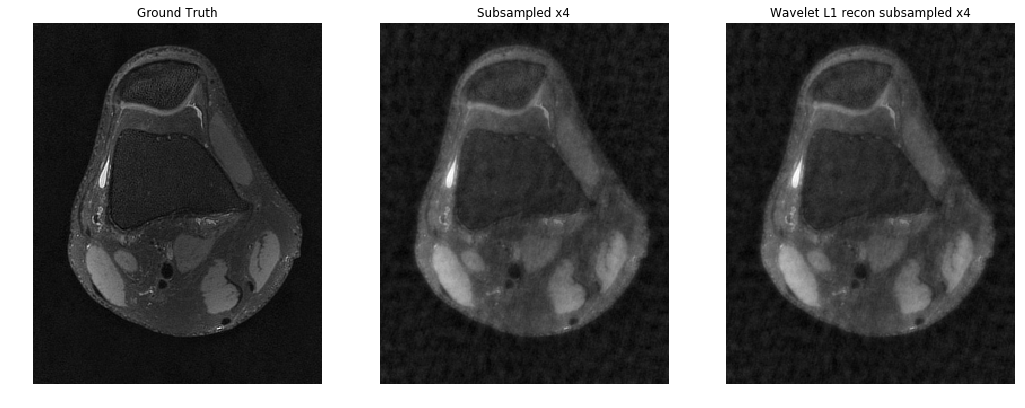

Reconstructions on subsampled x4:
Trial 0


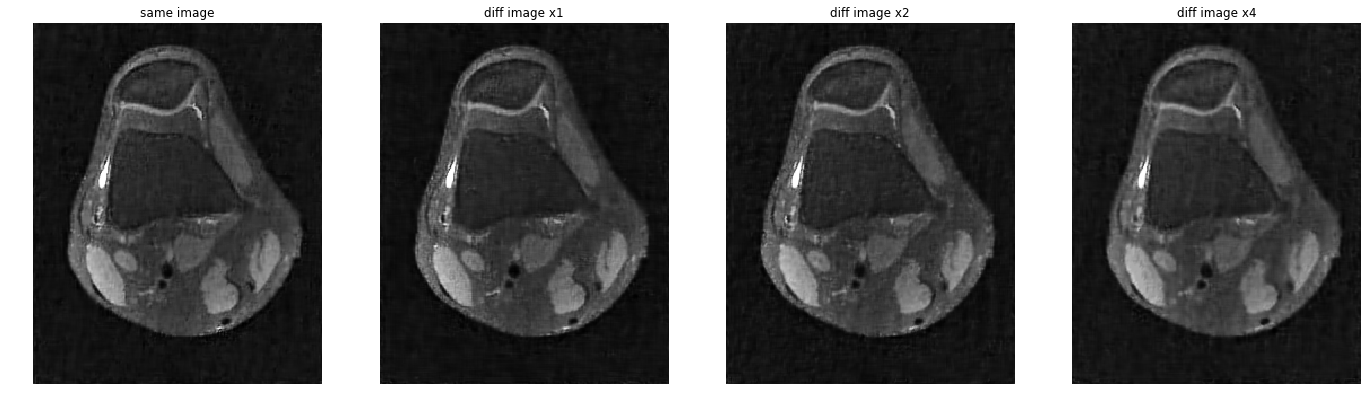

L1 errors:  [0.08585162214506448, 0.08559780041052753, 0.08622502883891975, 0.08665246081587026]
L2 errors:  [0.013368841106222282, 0.013330703251640921, 0.013416699626609971, 0.013561315639973098]
Trial 1


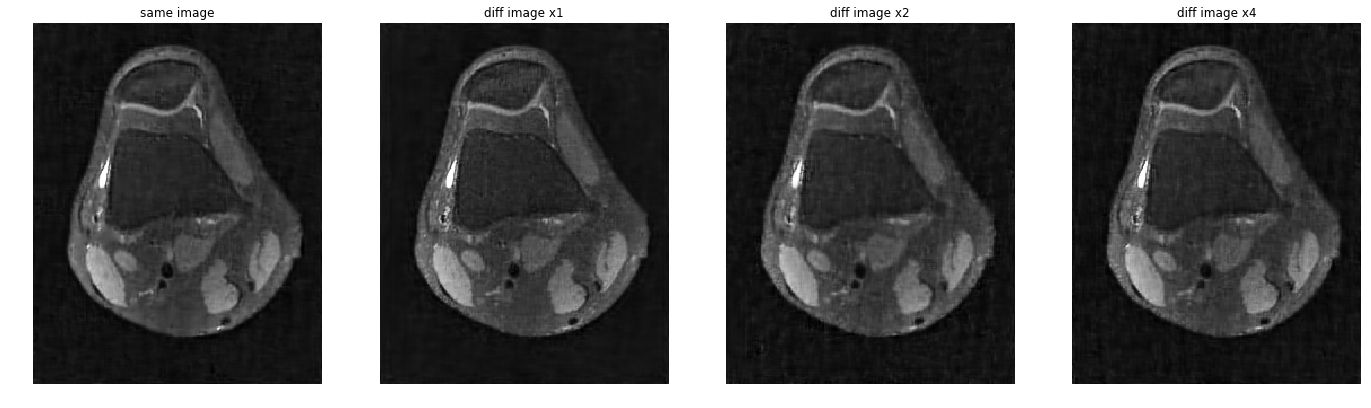

L1 errors:  [0.08577691357912369, 0.08473832220122639, 0.08657207852583781, 0.08683210398783517]
L2 errors:  [0.013342340304582515, 0.013083622430538872, 0.013679341352190382, 0.01364653352075304]
Trial 2


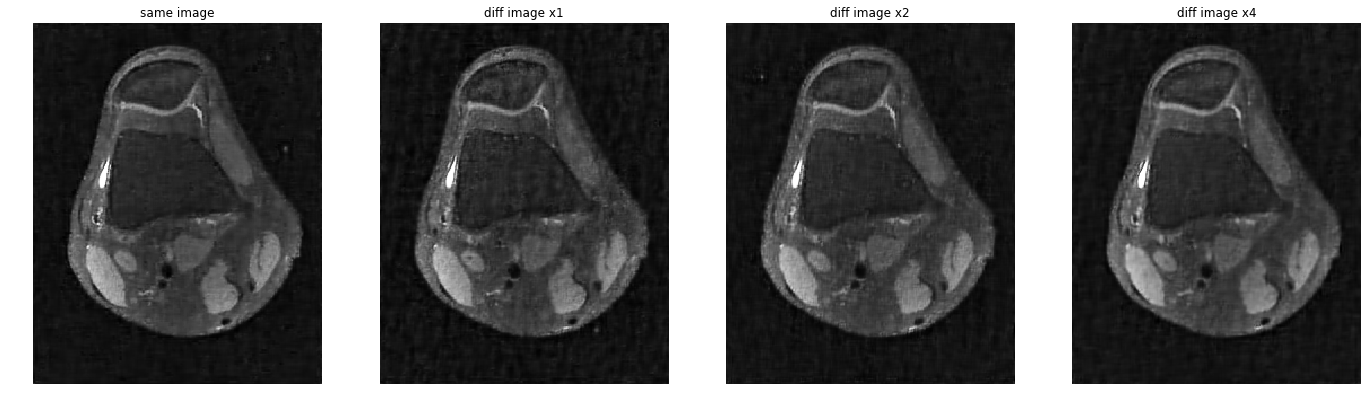

L1 errors:  [0.08569574080048029, 0.08834761550698089, 0.08646400059674458, 0.08710663846426572]
L2 errors:  [0.013313679116648871, 0.014126454449132953, 0.01356140800504128, 0.013762606570590072]


In [6]:

# compare same image, diff image, 2 diff, 4 diff
# each tested on same noise, each trained on diff noise (for batch, each elem has diff noise)
# show C:\Users\jains\Documents\GitHub\mri\deep_prior_data\diff_batch_sizes_gif_L1_noise for gifs
all_results = np.load('../deep_prior_data/comparisons/diff_batch_sizes_noise_L1.npy')
trials = 3
titles = ['same image', 'diff image x1', 'diff image x2', 'diff image x4']
plt.figure(figsize=(30,10))
plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
plt.subplot(152); plt.axis('off'); plt.title('Subsampled x4'); plt.imshow(subs_img_4[:, :, 0], cmap='gray')
plt.subplot(153); plt.axis('off'); plt.title('Wavelet L1 recon subsampled x4'); plt.imshow(wavelet_subs_4, cmap='gray')
plt.show()
print('Reconstructions on subsampled x4:')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    print('Trial {}'.format(i))
    for j in range(4): # tested 3 diff sizes
        curr = all_results[j][i]
        best, ind = get_best_L1(curr[0], orig_img)
        plt.subplot(151 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\pywt\_multilevel.py:664: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[a_slices] = a_coeffs
c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\pywt\_multilevel.py:690: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[slice_array] = d
GradientMethod:   0%|                                                                          | 0/100 [00:00<?, ?it/s]c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\pywt\_mul

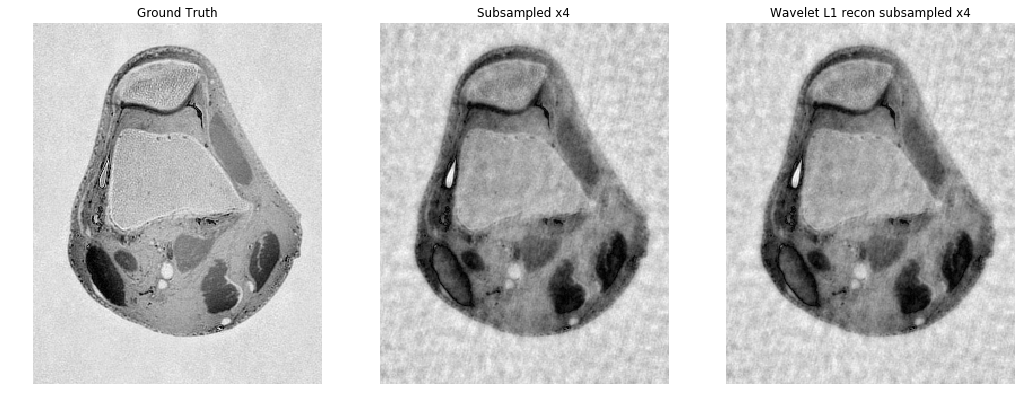

Reconstructions on subsampled x4:
Trial 0


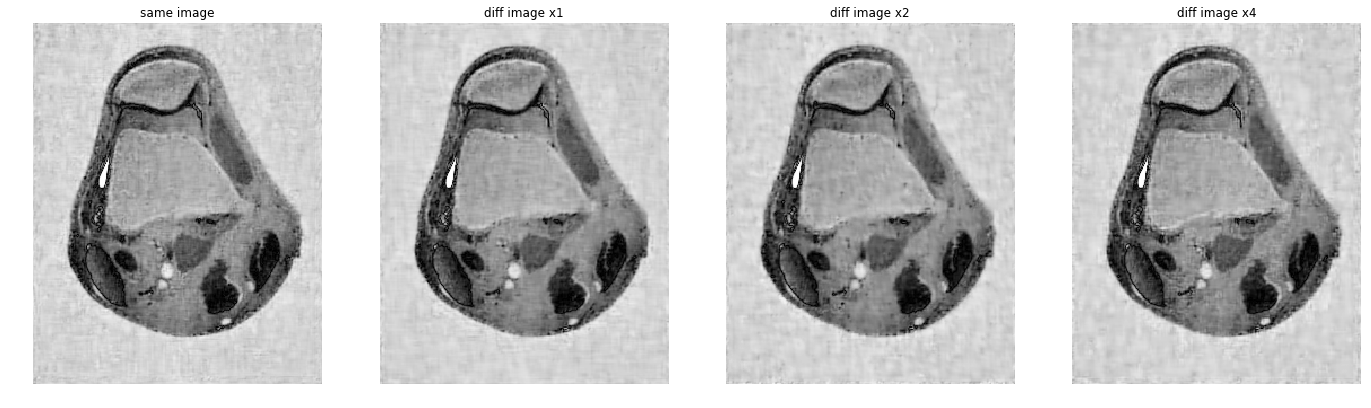

L1 errors:  [0.04789176081886017, 0.04827593913020307, 0.04880104611218517, 0.04827505540852271]
L2 errors:  [0.006434232985354099, 0.006409702979160466, 0.006564326074996201, 0.006505246441293652]
Trial 1


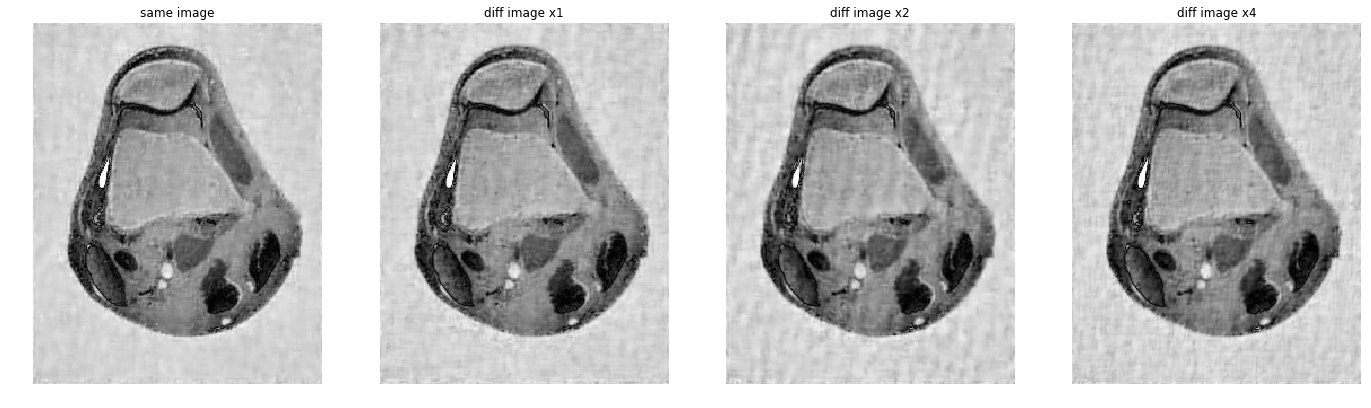

L1 errors:  [0.04774213028924655, 0.04861335745210114, 0.048693544141961795, 0.04858958613983943]
L2 errors:  [0.006354091474908884, 0.006487825573563359, 0.006753242863358866, 0.006639431098146911]
Trial 2


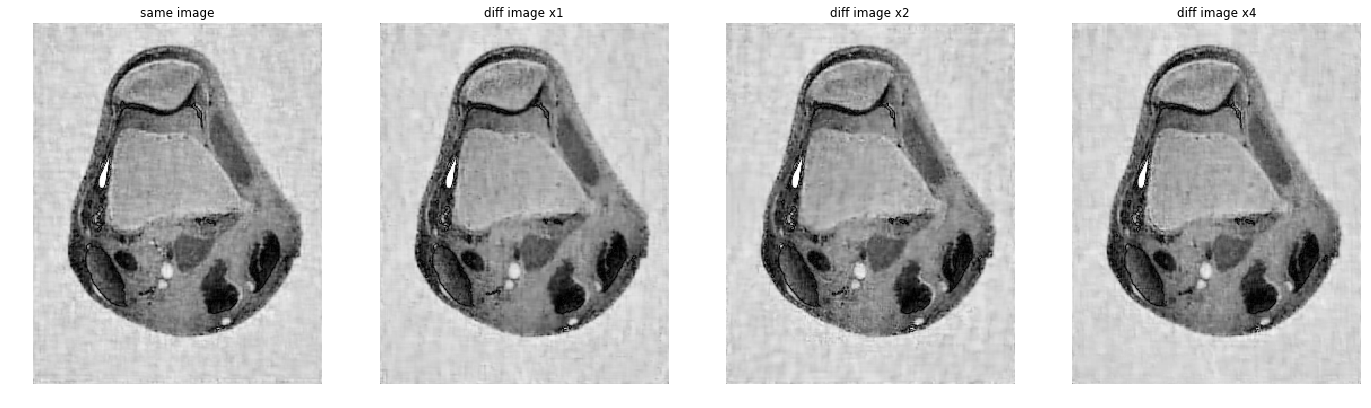

L1 errors:  [0.04850872757148641, 0.04816981331409709, 0.04810326836146776, 0.047811509331012754]
L2 errors:  [0.00649143866408265, 0.006475080398055823, 0.006462261854503127, 0.006432792573707045]


In [17]:
# compare same image, diff image, 2 diff, 4 diff
# each tested on same noise, each trained on diff noise (for batch, each elem has diff noise)
# show C:\Users\jains\Documents\GitHub\mri\deep_prior_data\diff_batch_sizes_gif_L1_noise for gifs

orig_img = get_image_normalized_2chan(100)
subs_img_4 = get_subsampled_normalized_2chan(orig_img, 4)
wavelet_subs_4 = get_wavelet_recon_2chan(subs_img_4)

all_results = np.load('../deep_prior_data/comparisons/diff_batch_sizes_2chan_L1.npy')
trials = 3
titles = ['same image', 'diff image x1', 'diff image x2', 'diff image x4']
plt.figure(figsize=(30,10))
plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(np.sqrt(orig_img[:, :, 0]**2 + orig_img[:, :, 1]**2), cmap='gray')
plt.subplot(152); plt.axis('off'); plt.title('Subsampled x4'); plt.imshow(np.sqrt(subs_img_4[:, :, 0]**2 + subs_img_4[:, :, 1]**2), cmap='gray')
plt.subplot(153); plt.axis('off'); plt.title('Wavelet L1 recon subsampled x4'); plt.imshow(wavelet_subs_4, cmap='gray')
plt.show()
print('Reconstructions on subsampled x4:')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    print('Trial {}'.format(i))
    for j in range(4): # tested 3 diff sizes
        curr = all_results[j][i]
        best, ind = get_best_L1_2chan(curr[0], orig_img)
        plt.subplot(151 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best, cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

Reconstructions:
Trial 0


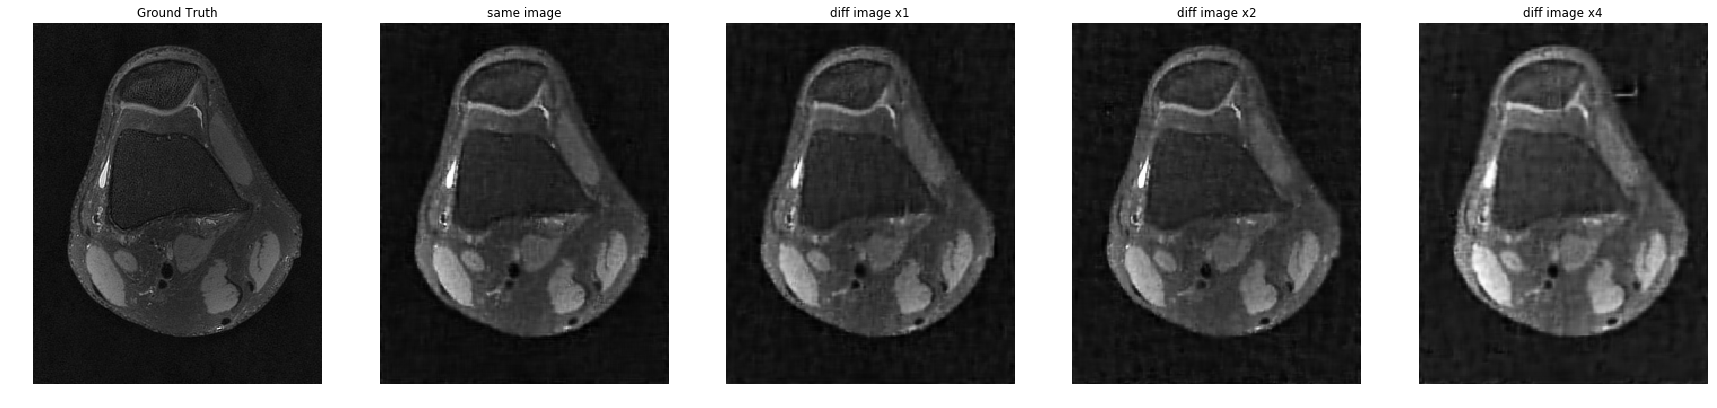

L1 errors:  [0.08506884940034187, 0.08616568772945146, 0.08727615797805913, 0.08691884540867897]
L2 errors:  [0.013229447483616227, 0.013571967299494225, 0.013644795873282373, 0.013952046903049537]
Trial 1


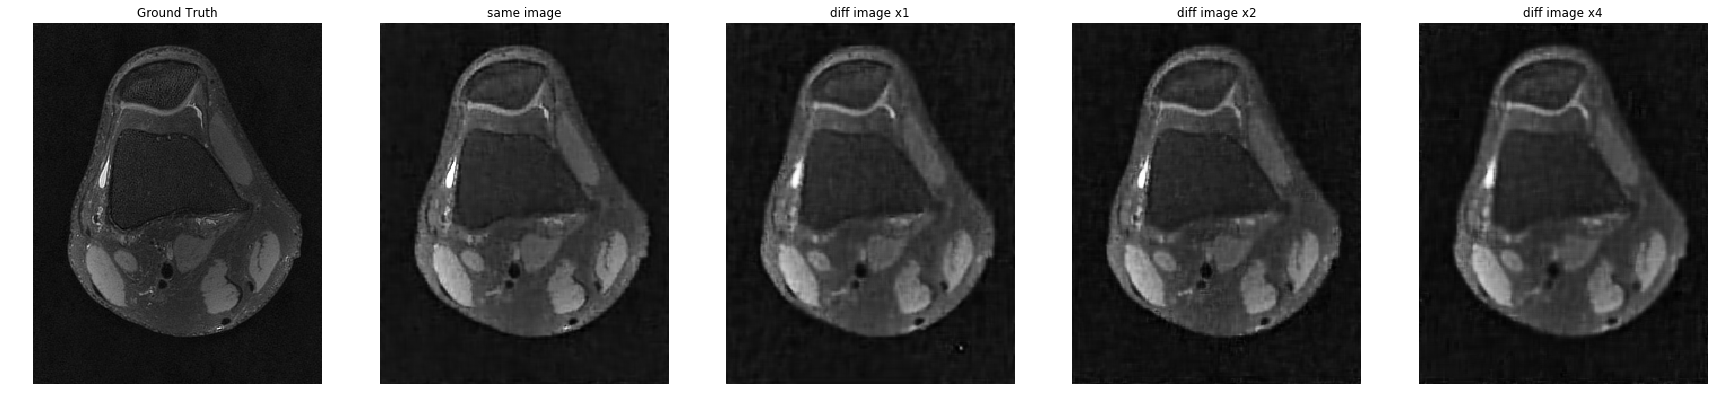

L1 errors:  [0.08504476720075468, 0.08631133036020484, 0.0860323692353458, 0.0862269589575575]
L2 errors:  [0.013007565198437729, 0.013737979047508602, 0.013494203016672219, 0.013689474862619119]
Trial 2


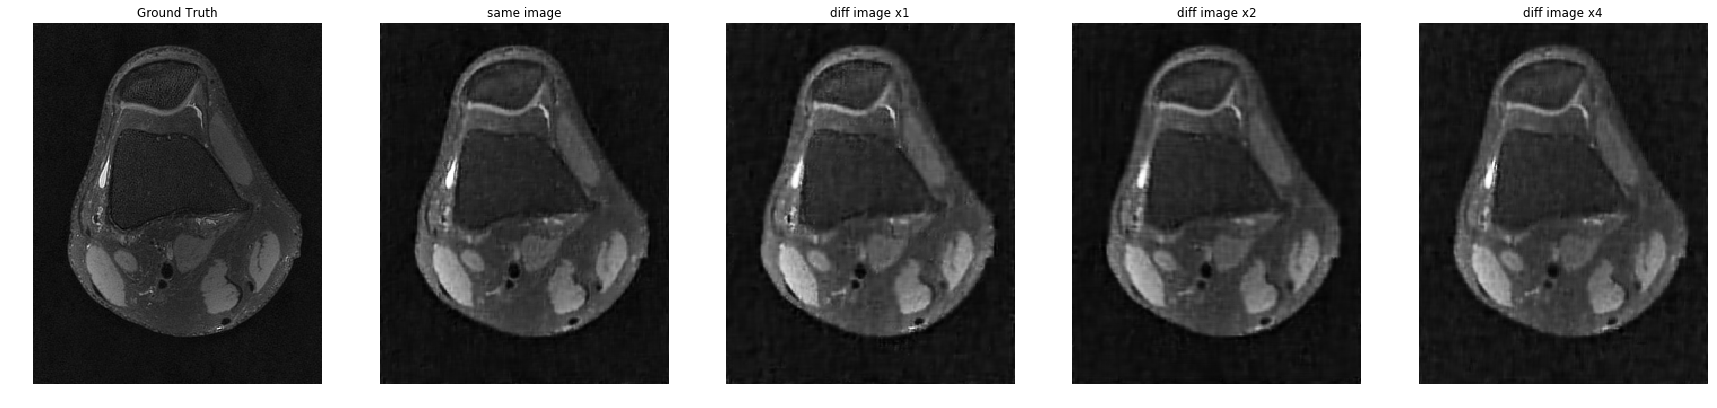

L1 errors:  [0.08524679833141999, 0.085548738991665, 0.08546199604952158, 0.08633672540396656]
L2 errors:  [0.01318277659736893, 0.013392491405373467, 0.013514916323817896, 0.01355783771832984]


In [15]:
# compare same image, diff image, 2 diff, 4 diff
# each trained and tested on same noise (for batch, each elem of batch uses same noise)
all_results = np.load('../deep_prior_data/comparisons/diff_batch_sizes_L1.npy')
trials = 3
titles = ['same image', 'diff image x1', 'diff image x2', 'diff image x4']
print('Reconstructions:')
for i in range(trials): # did 3 different noise values
    curr_L1 = []
    curr_L2 = []
    plt.figure(figsize=(30,10))
    plt.subplot(151); plt.axis('off'); plt.title('Ground Truth'); plt.imshow(orig_img[:, :, 0], cmap='gray')
    print('Trial {}'.format(i))
    for j in range(4): # tested 3 diff sizes
        curr = all_results[j][i]
        best, ind = get_best_L2(curr[0], orig_img)
        plt.subplot(152 + j); plt.axis('off'); plt.title(titles[j]); plt.imshow(best[:, :, 0], cmap='gray')
        curr_L1.append(curr[1][0][ind])
        curr_L2.append(curr[1][1][ind])
    plt.show()
    print('L1 errors: ', curr_L1)
    print('L2 errors: ', curr_L2)

(320, 256, 1)


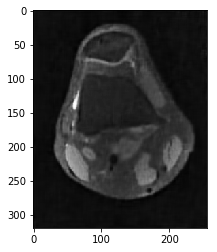

(320, 256, 1)


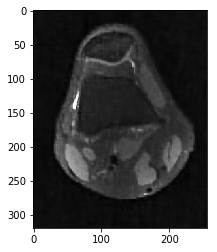

(320, 256, 1)


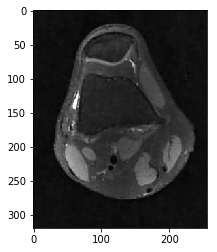

In [9]:
all_results = np.load('../deep_prior_data/images/big_batch_train_L1.npy')
curr = all_results[0][0]
print(np.shape(curr[0][0]))
plt.imshow(curr[0][-1][:, :, 0], cmap='gray')
plt.show()
all_results = np.load('../deep_prior_data/images/batch_train_L1.npy')
curr = all_results[0][0]
print(np.shape(curr[0][0]))
plt.imshow(curr[0][-1][:, :, 0], cmap='gray')
plt.show()
all_results = np.load('../deep_prior_data/images/same_train_L1.npy')
curr = all_results[0][0]
print(np.shape(curr[0][0]))
plt.imshow(curr[0][-1][:, :, 0], cmap='gray')
plt.show()